In [1]:
# packages
import os
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from tqdm.notebook import tqdm

import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

# constants
DATA_DIR = './data'
TRAIN_DIR, TEST_DIR = DATA_DIR + '/train', DATA_DIR + '/test'
TRAIN_CSV, TEST_CSV = DATA_DIR + '/train.csv', DATA_DIR + '/submission.csv'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

label_map = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles',
}

# hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 2
WEIGHT_DECAY = 0.0001

TRANSFORM_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180),
    transforms.RandomResizedCrop(128, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.RandomCrop(128, padding=4, padding_mode='reflect'),
    # transforms.Normalize(mean=[0.0793, 0.0530, 0.0545], std=[0.1290, 0.0886, 0.1376]),
])
TRANSFORM_test = transforms.Compose([
    transforms.ToTensor(),
])

sns.set_theme()
print('Using {} device'.format(DEVICE))

Using cpu device


In [2]:
# helper functions
def encode_label(label):
    """
    Converts a label string into a one-hot encoded tensor

    Args:
        label (str): label string of the form "1 2 3"

    Returns:
        torch.tensor: tensor of size 10 with 1s in the positions of the labels
    """	
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target


def decode_target(target, text_labels=False, threshold=0.5):
    """
    Converts a one-hot encoded tensor into a label string

    Args:
        target (torch.tensor): tensor of size 10 with 1s in the positions of the labels
        text_labels (bool): if True, returns the text labels and the label number in brackets
        threshold (float): threshold for the predictions

    Returns:
        str: label string of the form "1 2 3"
    """
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(label_map[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)


def show_sample(img, target, invert=True):
    """
    Displays a sample image and its labels

    Args:
        img (torch.tensor): image tensor of size 3x256x256
        target (torch.tensor): tensor of size 10 with 1s in the positions of the labels
        invert (bool): if True, inverts the image
    """
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))


def show_batch(dl, invert=True):
    """
    Displays a batch of images

    Args:
        dl (DataLoader): data loader
        invert (bool): if True, inverts the image
    """
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=8).permute(1, 2, 0))
        break
    

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

Number of labeled images: 15389 



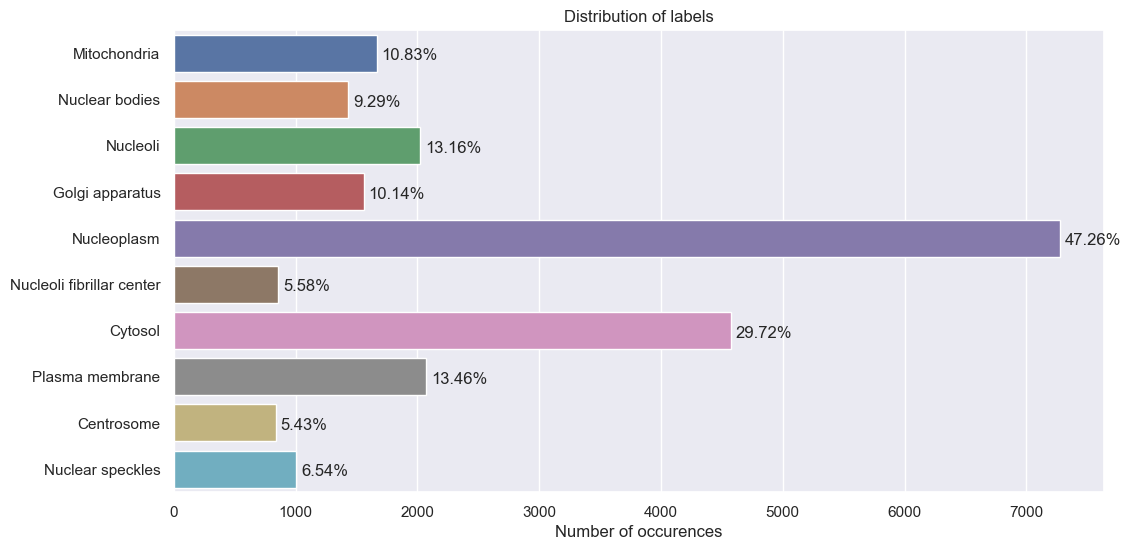

In [3]:
df = pd.read_csv(TRAIN_CSV)
print("Number of labeled images:", len(df), '\n')

# visualize class-imbalance
mlb = MultiLabelBinarizer()
counts = pd.DataFrame(
    mlb.fit_transform(df['Label'].apply(lambda x: x.split(' '))), 
    columns=mlb.classes_, index=df.index).sum()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    # use label_map as x
    x=counts.values,
    y=[label_map[i] for i in range(10)],
    orient='h',
    hue=[label_map[i] for i in range(10)],
    ax=ax)
ax.set_title("Distribution of labels")
ax.set(xlabel="Number of occurences")
for i, v in enumerate(counts.values):
    ax.text(v + 40, i + .15, str(np.round(100 * v / len(df), 2)) + '%')
plt.show()

Train samples      :  13854
Validation samples :  1535 

Example of a sample:
Labels: Nuclear bodies(1) Nucleoplasm(4)


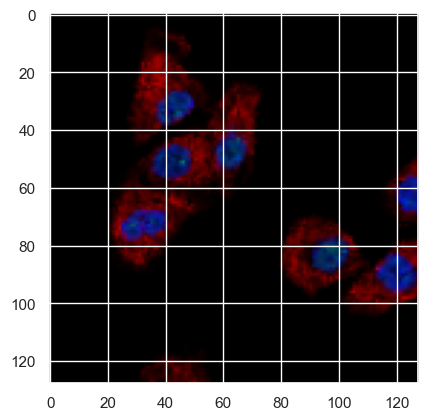

In [4]:
class HumanProteinDataset(Dataset):
    def __init__(self, X, y, root_dir, transform=None):
        self.df = pd.DataFrame({
            'Image': X.reshape(-1),
            'Label': [decode_target(l) for l in y]})
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)


# stratified split
X = df['Image']
y = pd.DataFrame(mlb.fit_transform(df['Label'].apply(lambda x: x.split(' '))), columns=mlb.classes_, index=df.index)
X_train, y_train, X_val, y_val = iterative_train_test_split(X.values.reshape(-1, 1), y.values, test_size=0.1)

# create datasets
train_ds = HumanProteinDataset(X_train, y_train, TRAIN_DIR, transform=TRANSFORM_train)
val_ds = HumanProteinDataset(X_val, y_val, TRAIN_DIR, transform=TRANSFORM_test)

print("Train samples      : ", len(train_ds))
print("Validation samples : ", len(val_ds), '\n')
print("Example of a sample:")
show_sample(*train_ds[0], invert=False)

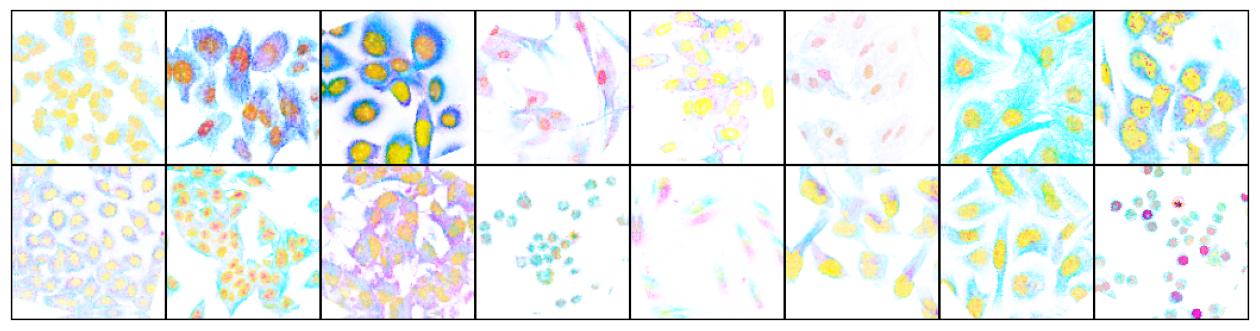

In [5]:
# data loaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

# visualize a batch of data
show_batch(train_dl)

In [6]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

class ProteinCnnModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        return self.network(xb)

model = ProteinCnnModel().to(DEVICE)

In [7]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape :', images.shape)
        out = model(images)
        print('out.shape    :', out.shape)
        print('out[0]       :', [round(float(x), 3) for x in out[0]])
        break

try_batch(train_dl)

images.shape : torch.Size([16, 3, 128, 128])
out.shape    : torch.Size([16, 10])
out[0]       : [0.466, 0.481, 0.513, 0.473, 0.476, 0.523, 0.459, 0.466, 0.497, 0.514]


In [14]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

def plot_history(history):
    """
    Plots the train and validation loss and validation F1 score
    """
    train_losses = [x.get('train_loss') for x in history]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    val_losses = [x['val_loss'] for x in history]
    val_scores = [x['val_score'] for x in history]

    ax1.plot(train_losses, '-bx')
    ax1.plot(val_losses, '-rx')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend(['Training', 'Validation'])
    ax1.title.set_text('Loss vs. No. of epochs')

    ax2.plot(val_scores, '-rx')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('F1 score')
    ax2.title.set_text('F1 score vs. No. of epochs')

  0%|          | 0/866 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.3879, val_loss: 0.3748, val_score: 0.3646


  0%|          | 0/866 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.3745, val_loss: 0.3747, val_score: 0.3644


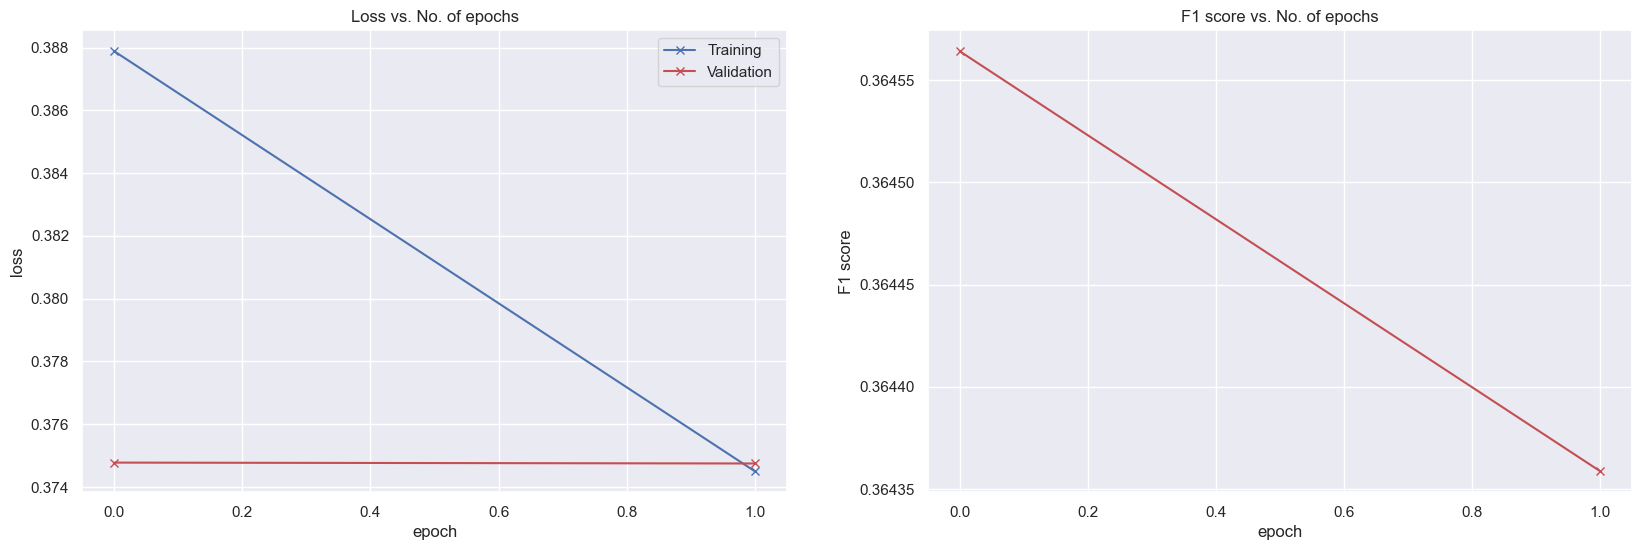

In [9]:
history = fit(NUM_EPOCHS, LEARNING_RATE, model, train_dl, val_dl, opt_func=torch.optim.Adam)
plot_history(history)

Prediction:  tensor([0.1239, 0.0777, 0.1345, 0.1080, 0.5282, 0.0675, 0.3258, 0.1397, 0.0565,
        0.0711], grad_fn=<SelectBackward0>)
Labels: Nucleoplasm(4)


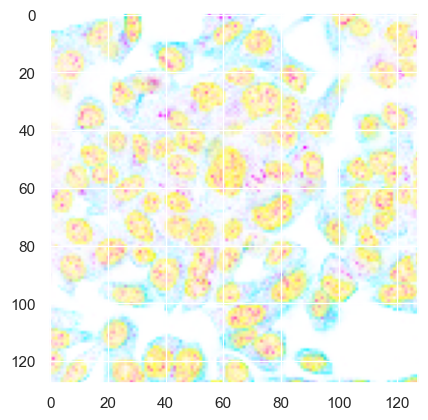

In [10]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, DEVICE)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

test_df = pd.read_csv(TEST_CSV)
test_ds = HumanProteinDataset(
    X = test_df['Image'].values.reshape(-1, 1),
    y = [[1] + [0] * 9] * len(test_df),
    root_dir = TEST_DIR,
    transform = TRANSFORM_test
)

predict_single(test_ds[100][0])

In [11]:
test_dl = DeviceDataLoader(DataLoader(test_ds, BATCH_SIZE), DEVICE)

def predict_dl(dl, model):
    model.eval()
    with torch.no_grad():
        torch.cuda.empty_cache()
        batch_probs = []
        for xb, _ in tqdm(dl):
            probs = model(xb)
            batch_probs.append(probs.cpu().detach())
        batch_probs = torch.cat(batch_probs)
        return [decode_target(x) for x in batch_probs]

- Maybe try several thresholds and see which gives the best results score?
- Cross-validation and average the results? [here](https://www.kaggle.com/code/ronaldokun/multilabel-stratification-cv-and-ensemble)

In [12]:
test_preds = predict_dl(test_dl, model)
submission_df = pd.read_csv(TEST_CSV)
submission_df["Label"] = test_preds
submission_df.head()

  0%|          | 0/241 [00:00<?, ?it/s]

,Image,Label
0,25880,4
1,7810,4
2,23748,4
3,24621,4
4,30169,4


In [13]:
submission_df.to_csv('submission.csv', index=False)